In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw
from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from eofs.standard import Eof

from dateutil        import parser
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
DEBUG:shapely.geos:Trying `CDLL(libgeos_c.so.1)`
DEBUG:shapely.geos:Trying `CDLL(libgeos_c.so)`
DEBUG:shapely.geos:Trying `CDLL(/home/ssahu/anaconda3/lib/libgeos_c.so)`
DEBUG:shapely.geos:Library path: '/home/ssahu/anaconda3/lib/libgeos_c.so'
DEBUG:shapely.geos:DLL: <CDLL '/home/ssahu/anaconda3/lib/libgeos_c.so', handle 2c6d280 at 0x7f87083f8ac8>
DEBUG:shapely.geos:Trying `CDLL(libc.so.6)`
DEBUG:shapely.geos:Library path: 'libc.so.6'
DEBUG:shapely.geos:DLL: <CDLL 'libc.so.6', handle 7f8750e54000 at 0x7f8708467470>


In [55]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

# tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
# umask = mask.variables['umask'][0,:32,180:350, 480:650]
# vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
# mbathy = mask.variables['mbathy'][0,180:350, 480:650]

tmask = mask.variables['tmask'][0,:,220:280, 580:630]
umask = mask.variables['umask'][0,:,220:280, 580:630]
vmask = mask.variables['vmask'][0,:,220:280, 580:630]
mbathy = mask.variables['mbathy'][0,220:280, 580:630]


# y_wcvi_slice = np.array(np.arange(220,280))
# x_wcvi_slice = np.array(np.arange(590,650))
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# mbathy[mbathy>32] = 32

bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']#[220:280, 580:630]
lat = bathy['nav_lat']#[220:280, 580:630]

In [3]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [4]:
isot[2]

26.200001

In [5]:
def add_model_MVP_data(survey_file, iso_level, survey_iso_spic, model_spic):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic




In [6]:
survey_mat_file_A = '/data/ssahu/Falkor_2013/mvp/surveyA.mat'
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'


all_surveys = [survey_mat_file_A, survey_mat_file_B, survey_mat_file_D, \
              survey_mat_file_E, survey_mat_file_G]

In [7]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [8]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [9]:
def get_stat(obs, model):
    
    model_interp = model

    obar = np.nanmean(obs)
    mprime = model_interp - obar
    oprime = obs - obar

    diff_sq = np.sum((model_interp-obs)**2)
    add_sq = np.sum((np.abs(mprime) + np.abs(oprime))**2)

    ws = 1-diff_sq/add_sq



    error = model_interp - obs
    gamma2 = np.var(error)/np.var(obs)
    mean_error = np.mean(error)
    mean_abs_error = np.mean(np.abs(error))
    rms_error = np.sqrt(np.mean(error**2))
    
    return gamma2,rms_error,ws



In [10]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):

        self.sg.fig.set_size_inches(self.fig.get_size_inches())

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [11]:
sns.set(font_scale=1.2)


In [12]:
df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [28]:
labels = cluster.KMeans((), {'n_clusters':4}).fit_predict(df)

# plot_clusters(df, cluster.KMeans, (), {'n_clusters':4})

# labels = algorithm(*args, **kwds).fit_predict(data)

TypeError: unorderable types: int() < tuple()

In [44]:
def plot_clusters(ax, data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    ax.scatter(survey_iso_spic, model_spic, c=colors, **plot_kwds)
    return labels, colors
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
#     plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
#     plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)


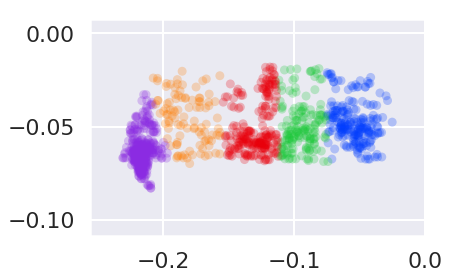

In [15]:
labels,colors = plot_clusters(df, cluster.KMeans, (), {'n_clusters':5})

In [16]:
colors = np.array(colors)

colors[1,:]

array([ 0.90980392,  0.        ,  0.04313725])

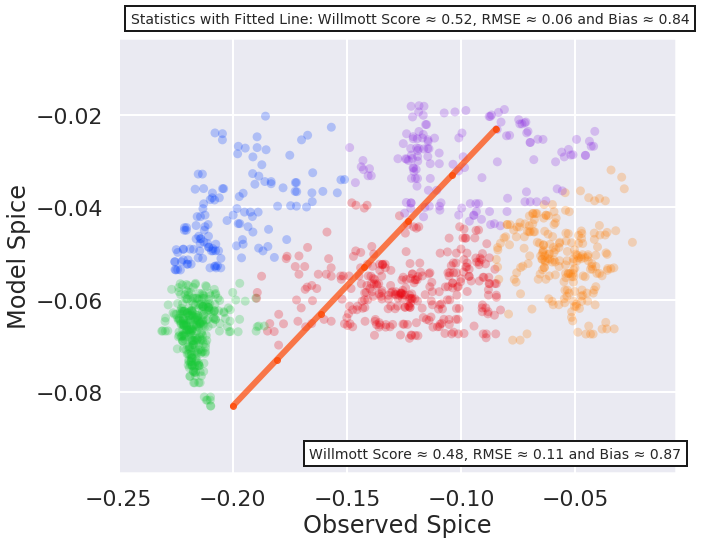

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

labels,colors = plot_clusters(df, cluster.SpectralClustering, (), {'n_clusters':5})
ax.set_xlabel("Observed Spice")
ax.set_ylabel("Model Spice")

ax.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)


gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0.32, 0.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)

# ax.axhline(y=-0.055, c = 'teal')
# ax.axvline(x= -0.17, c = 'teal')

# ax.axhline(y=-0.037, c = 'red')


In [32]:
cluster_1_obs   = survey_iso_spic[labels == 0]
cluster_1_model = model_spic[labels == 0]


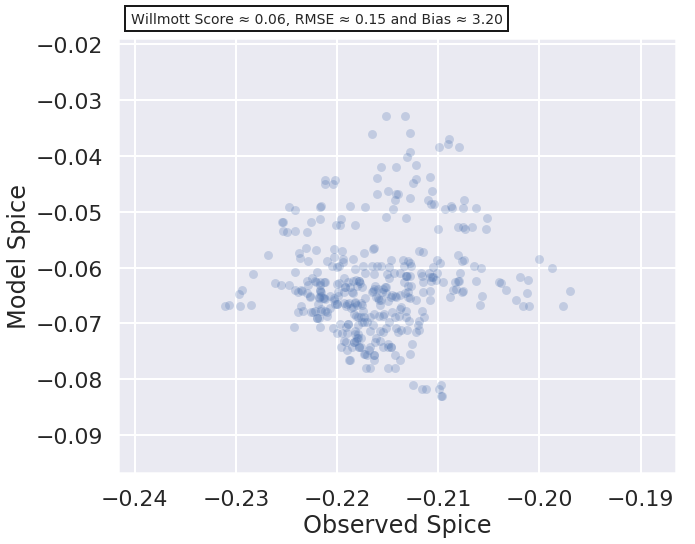

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = cluster_1_obs
df['Model Spice'] = cluster_1_model


q = df.plot.scatter(x="Observed Spice", y="Model Spice",ax = ax, **plot_kwds)



# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
# q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)


# # lims = [
# #     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
# #     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# # ]
# # ax.tick_params(axis='both',labelsize =16)

# q.set_axis_labels('Observed Spice', 'Model Spice')
# fig = q.fig
# fig.set_figwidth(10)
# fig.set_figheight(10)

In [34]:
cluster_1_model.shape

(373,)

In [35]:
survey_iso_spic.shape

(1085,)

In [20]:
def calcuate_location_of_kde_custers_kmeans_5(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1):#,\
#                                     y_added_2,x_added_2,y_added_3,x_added_3, y_added_4,x_added_4,\
#                                              y_added_5,x_added_5):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]
        



    
    df =pd.DataFrame()
    df['Observed Spice'] = spic_rho_finite1[~np.isnan(model_add)]
    df['Model Spice'] = model_add[~np.isnan(model_add)]
    
    y = y[~np.isnan(model_add)]
    x = x[~np.isnan(model_add)]
    
    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)    

    model_spic = np.append(arr= model_spic, values=model_add)
    

    
#     def plot_clusters(data, algorithm, args, kwds):
# #         start_time = time.time()
#         labels = algorithm(*args, **kwds).fit_predict(data)
# #         end_time = time.time()
# #         palette = sns.color_palette('deep', np.unique(labels).max() + 1)
# #         colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
# #         plt.scatter(survey_iso_spic, model_spic, c=colors, **plot_kwds)
#         return labels
    
#     labels = plot_clusters(df, cluster.KMeans, (), {'n_clusters':5})
    
    y_1 = y[:]
    x_1 = x[:]
    
#     y_264_cluster_2 = y[labels == 1]
#     x_264_cluster_2 = x[labels == 1]
    
#     y_264_cluster_3 = y[labels == 2]
#     x_264_cluster_3 = x[labels == 2]
    
#     y_264_cluster_4 = y[labels == 3]
#     x_264_cluster_4 = x[labels == 3]
    
#     y_264_cluster_5 = y[labels == 4]
#     x_264_cluster_5 = x[labels == 4]
    
    
#     y_264_cluster_1 = y[spic_rho_finite1<=-0.21]
#     x_264_cluster_1 = x[spic_rho_finite1<=-0.21]
    
#     y_264_cluster_2 = y[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
#     x_264_cluster_2 = x[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
    
#     y_264_cluster_3 = y[spic_rho_finite1>=-0.10]
#     x_264_cluster_3 = x[spic_rho_finite1>=-0.10]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_1)
    
#     y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
#     x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
#     y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
#     x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
#     y_added_4 = np.append(arr= y_added_4,  values= y_264_cluster_4)
#     x_added_4 = np.append(arr= x_added_4,  values= x_264_cluster_4)
    
#     y_added_5 = np.append(arr= y_added_5,  values= y_264_cluster_5)
#     x_added_5 = np.append(arr= x_added_5,  values= x_264_cluster_5)

    
    return survey_iso_spic, model_spic, y_added_1, x_added_1#, y_added_2, x_added_2, y_added_3, x_added_3, y_added_4, x_added_4, \
# y_added_5, x_added_5



In [21]:

    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
# y_added_2 = []
# x_added_2 = []
# y_added_3 = []
# x_added_3 = []
# y_added_4 = []
# x_added_4 = []
# y_added_5 = []
# x_added_5 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1 \
    = calcuate_location_of_kde_custers_kmeans_5(survey_file=survey_file, \
                                                iso_level=4,model_spic=model_spic, \
                                                survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1)#,\
#                                                 y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3,\
#                                                y_added_4=y_added_4,x_added_4=x_added_4, \
#                                                y_added_5=y_added_5,x_added_5=x_added_5)

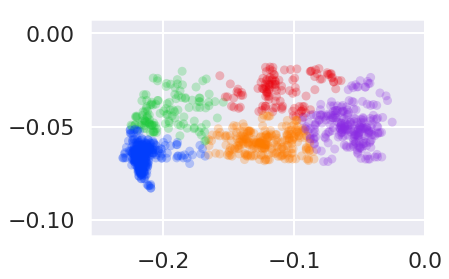

In [34]:
# df =pd.DataFrame()

df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic

labels, colors = plot_clusters(df, cluster.KMeans, (), {'n_clusters':5})

colors = np.array(colors)

In [35]:
colors1 = colors[labels == 0]

In [30]:

y_264_cluster_1 = y_added_1[labels == 0]
x_264_cluster_1 = x_added_1[labels == 0]

y_264_cluster_2 = y_added_1[labels == 1]
x_264_cluster_2 = x_added_1[labels == 1]

y_264_cluster_3 = y_added_1[labels == 2]
x_264_cluster_3 = x_added_1[labels == 2]

y_264_cluster_4 = y_added_1[labels == 3]
x_264_cluster_4 = x_added_1[labels == 3]

y_264_cluster_5 = y_added_1[labels == 4]
x_264_cluster_5 = x_added_1[labels == 4]

(560, 640)

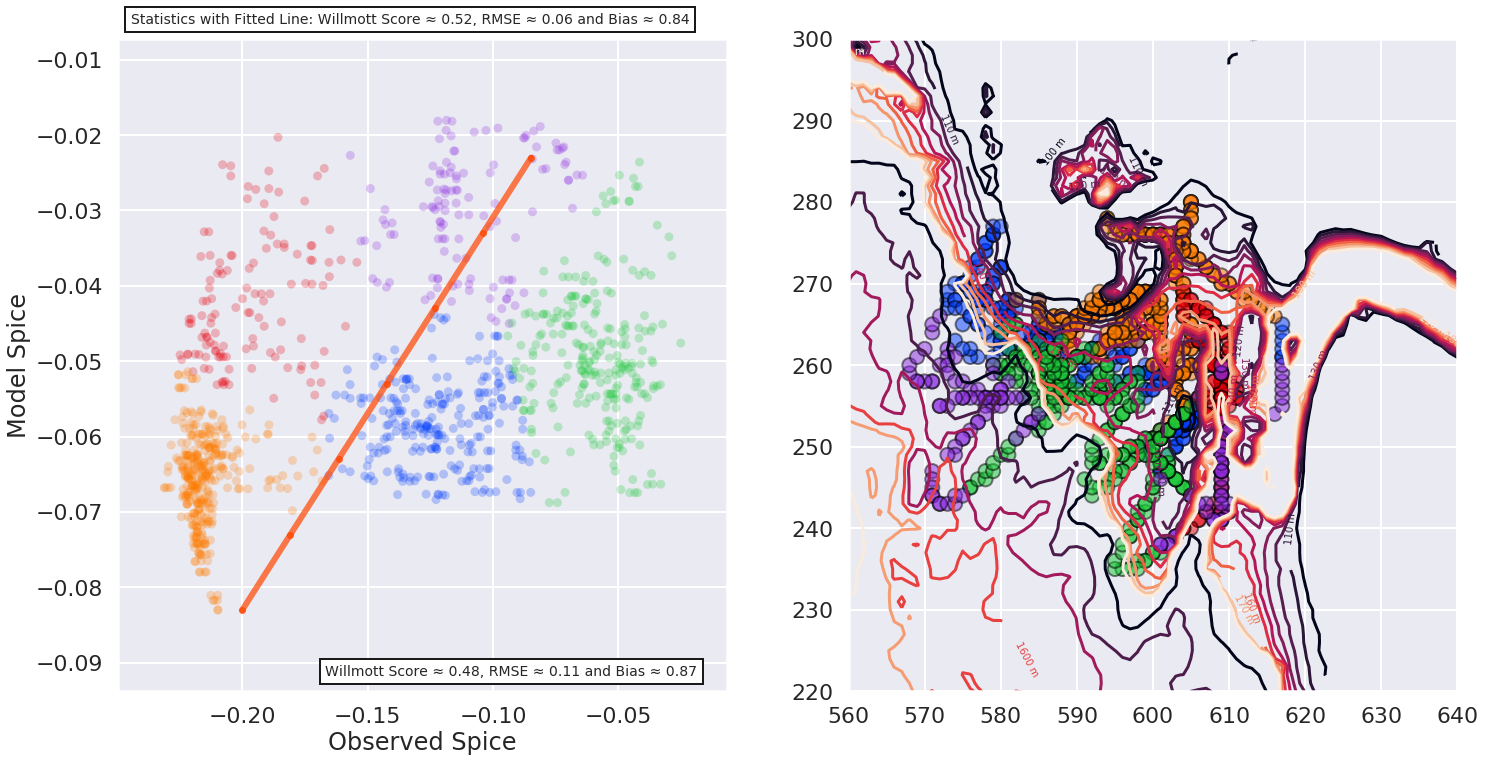

In [58]:
fig, (ax1,ax) = plt.subplots(1,2, figsize=(24,12))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

labels, colors = plot_clusters(ax=ax1, data=df, algorithm=cluster.KMeans, args=(), kwds={'n_clusters':5})
colors = np.array(colors)
ax1.set_xlabel("Observed Spice")
ax1.set_ylabel("Model Spice")

ax1.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax1.transAxes
                       )
ax1.add_artist(anchored_text)


gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0.32, 0.),
                       bbox_transform=ax1.transAxes
                       )
ax1.add_artist(anchored_text)

# ax.axhline(y=-0.055, c = 'teal')
# ax.axvline(x= -0.17, c = 'teal')

# ax.axhline(y=-0.037, c = 'red')


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# cmap = plt.get_cmap('deep')
# cmap = sns.color_palette('bright', np.unique(labels).max() + 1)
#     cmap.set_bad('burlywood')
# cmap.set_bad('#8b7765')
# fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



y_264_cluster_1 = y_added_1[labels == 0]
x_264_cluster_1 = x_added_1[labels == 0]

y_264_cluster_2 = y_added_1[labels == 1]
x_264_cluster_2 = x_added_1[labels == 1]

y_264_cluster_3 = y_added_1[labels == 2]
x_264_cluster_3 = x_added_1[labels == 2]

y_264_cluster_4 = y_added_1[labels == 3]
x_264_cluster_4 = x_added_1[labels == 3]

y_264_cluster_5 = y_added_1[labels == 4]
x_264_cluster_5 = x_added_1[labels == 4]


for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha= 0.5, s=200, edgecolor= 'black', label = 'cluster 1')

for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')

for i in np.arange(x_264_cluster_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 3')

for i in np.arange(x_264_cluster_4.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 4')

for i in np.arange(x_264_cluster_5.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')

ax.set_ylim(220,300)
ax.set_xlim(560,640)


(560, 640)

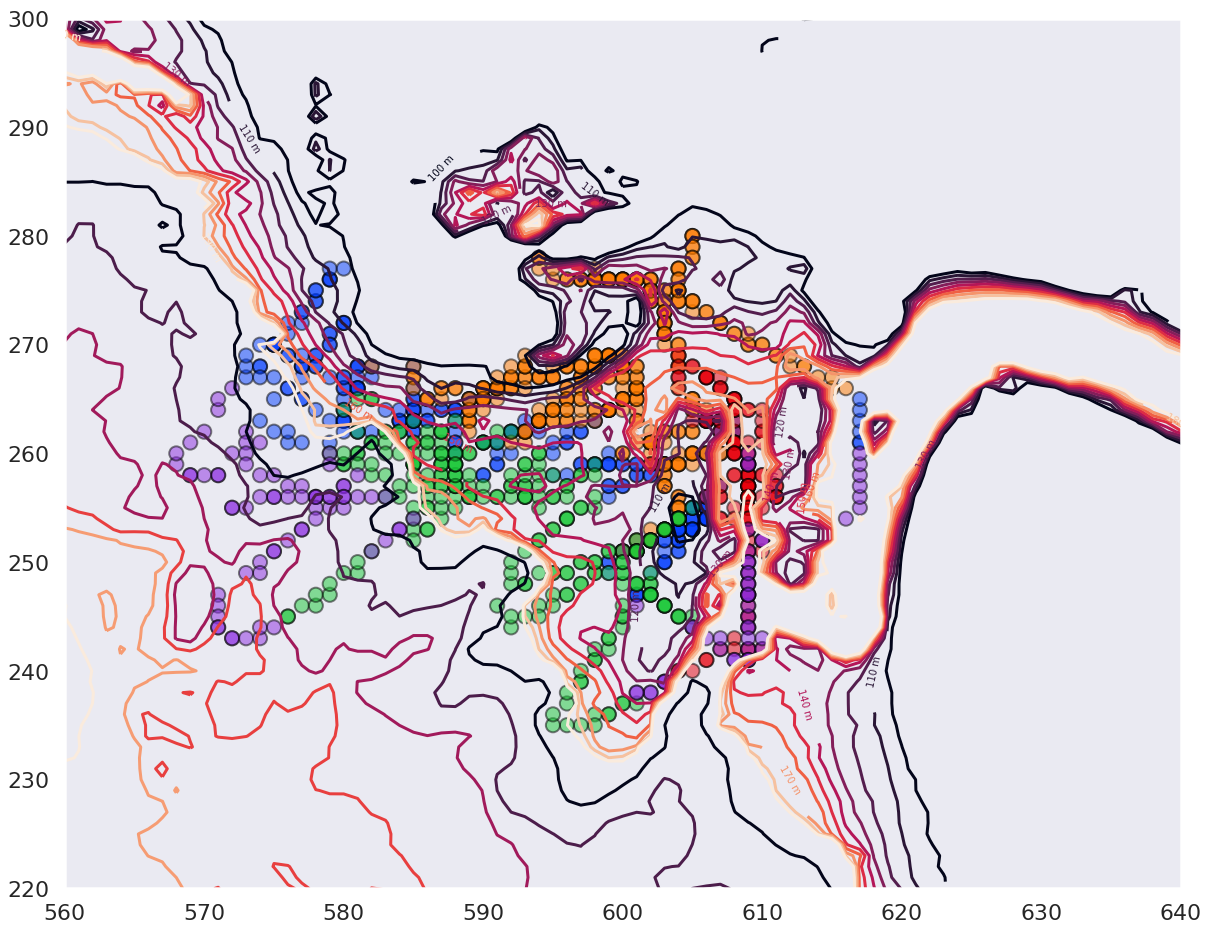

In [59]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# cmap = plt.get_cmap('deep')
cmap = sns.color_palette('bright', np.unique(labels).max() + 1)
#     cmap.set_bad('burlywood')
# cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_264_cluster_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_1[i])], y_wcvi_slice[np.int(y_264_cluster_1[i])], c = colors[labels == 0], alpha= 0.5, s=200, edgecolor= 'black', label = 'cluster 1')

for i in np.arange(x_264_cluster_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_2[i])], y_wcvi_slice[np.int(y_264_cluster_2[i])], c = colors[labels == 1], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 2')

for i in np.arange(x_264_cluster_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_3[i])], y_wcvi_slice[np.int(y_264_cluster_3[i])], c = colors[labels == 2], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 3')

for i in np.arange(x_264_cluster_4.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_4[i])], y_wcvi_slice[np.int(y_264_cluster_4[i])], c = colors[labels == 3], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 4')

for i in np.arange(x_264_cluster_5.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_264_cluster_5[i])], y_wcvi_slice[np.int(y_264_cluster_5[i])], c = colors[labels == 4], alpha =0.5, s=200, edgecolor= 'black', label = 'cluster 5')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

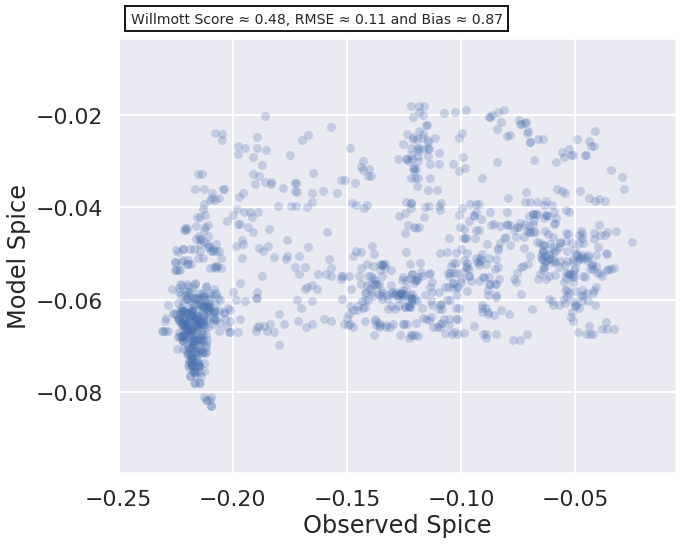

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

q = df.plot.scatter(x="Observed Spice", y="Model Spice",ax = ax, **plot_kwds)



# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
# q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)


# # lims = [
# #     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
# #     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# # ]
# # ax.tick_params(axis='both',labelsize =16)

# q.set_axis_labels('Observed Spice', 'Model Spice')
# fig = q.fig
# fig.set_figwidth(10)
# fig.set_figheight(10)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# >>> def func(x, a, b, c):
# #     return a * np.exp(-b * x) + c

# calculate polynomial
z = np.polyfit(df['Model Spice'],df['Observed Spice'], 1)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.arange(np.min(df['Model Spice']), np.max(df['Model Spice']), 0.01)
y_new = f(x_new)

x_fit = df['Model Spice']
y_fit = f(x_fit)


df['Fitted Spice'] = y_fit

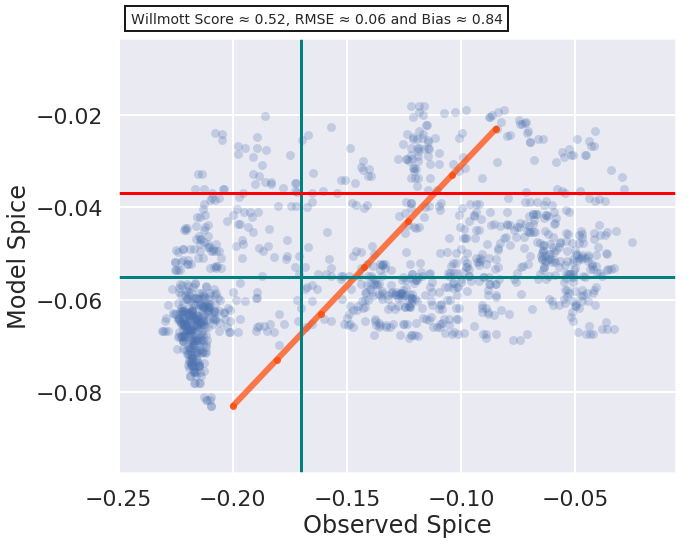

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

q = df.plot.scatter(x="Observed Spice", y="Model Spice",ax = ax, **plot_kwds)

ax.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)

ax.axhline(y=-0.055, c = 'teal')
ax.axvline(x= -0.17, c = 'teal')

ax.axhline(y=-0.037, c = 'red')


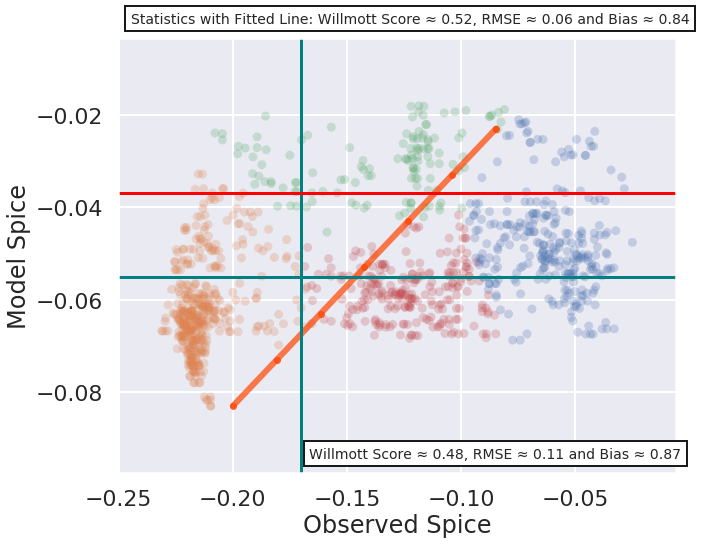

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':4})
ax.set_xlabel("Observed Spice")
ax.set_ylabel("Model Spice")

ax.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)


gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0.32, 0.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)

ax.axhline(y=-0.055, c = 'teal')
ax.axvline(x= -0.17, c = 'teal')

ax.axhline(y=-0.037, c = 'red')


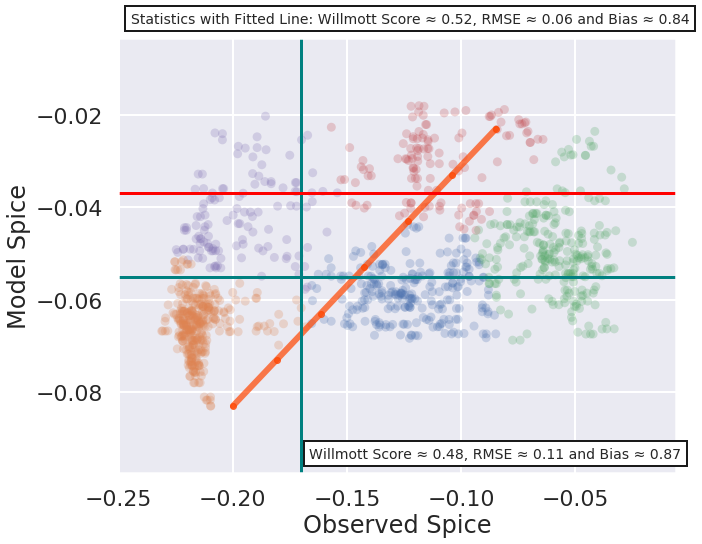

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':5})
ax.set_xlabel("Observed Spice")
ax.set_ylabel("Model Spice")

ax.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)


gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0.32, 0.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)

ax.axhline(y=-0.055, c = 'teal')
ax.axvline(x= -0.17, c = 'teal')

ax.axhline(y=-0.037, c = 'red')


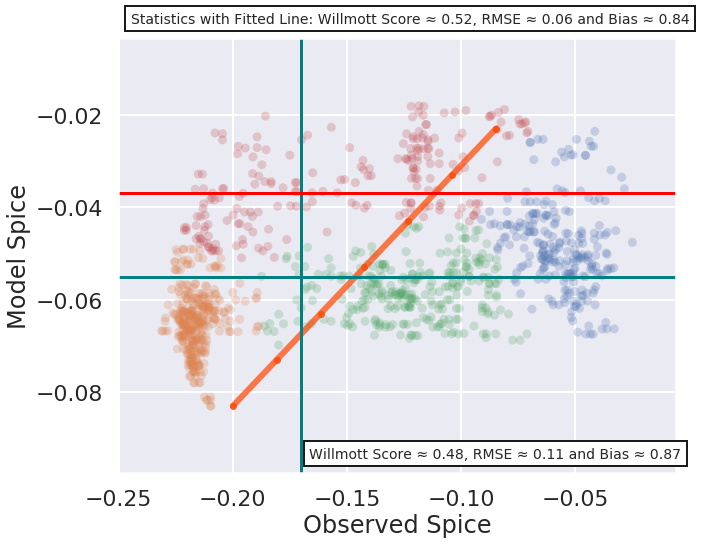

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = plot_clusters(df, cluster.KMeans, (), {'n_clusters':3})

q = plot_clusters(df, cluster.SpectralClustering, (), {'n_clusters':4})
ax.set_xlabel("Observed Spice")
ax.set_ylabel("Model Spice")

ax.plot(y_new, x_new, lw=6, c='orangered', marker='.', alpha=0.7)

gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Fitted Spice'])
anchored_text = AnchoredText("Statistics with Fitted Line: Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)


gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(0.32, 0.),
                       bbox_transform=ax.transAxes
                       )
ax.add_artist(anchored_text)

ax.axhline(y=-0.055, c = 'teal')
ax.axvline(x= -0.17, c = 'teal')

ax.axhline(y=-0.037, c = 'red')


(560, 640)

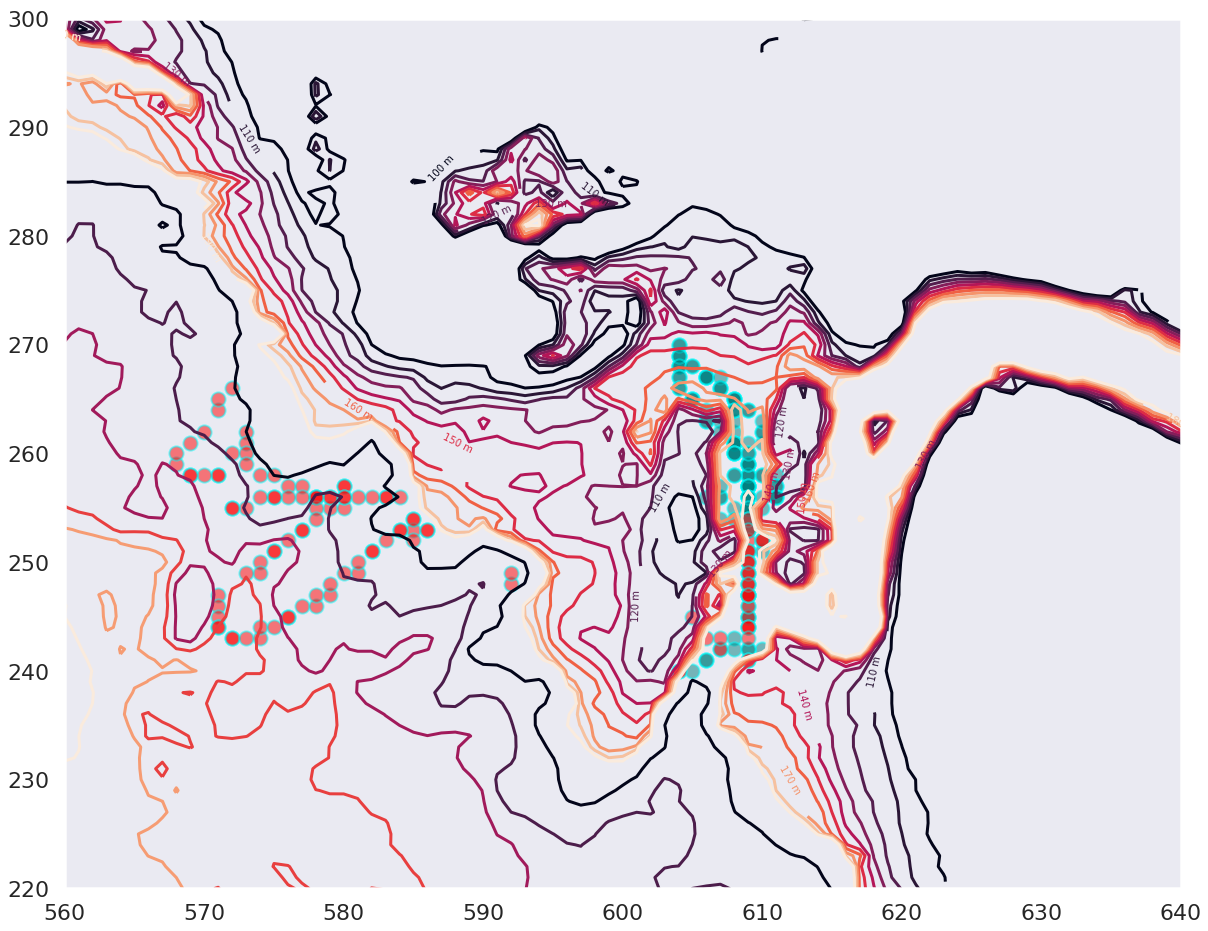

In [51]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'teal', alpha= 0.5, s=200, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

In [52]:
def calcuate_location_of_kde_custers(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1,\
                                     y_added_2,x_added_2,y_added_3,x_added_3):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    y_264_cluster_1 = y[spic_rho_finite1<=-0.21]
    x_264_cluster_1 = x[spic_rho_finite1<=-0.21]
    
    y_264_cluster_2 = y[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
    x_264_cluster_2 = x[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
    
    y_264_cluster_3 = y[spic_rho_finite1>=-0.10]
    x_264_cluster_3 = x[spic_rho_finite1>=-0.10]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_264_cluster_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_264_cluster_1)
    
    y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
    x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
    y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
    x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
    return survey_iso_spic, model_spic, y_added_1, x_added_1, y_added_2, x_added_2, y_added_3, x_added_3



In [53]:

    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
y_added_2 = []
x_added_2 = []
y_added_3 = []
x_added_3 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1, \
    y_added_2, x_added_2, y_added_3, x_added_3 \
    = calcuate_location_of_kde_custers(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1,\
                                      y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3)

(560, 640)

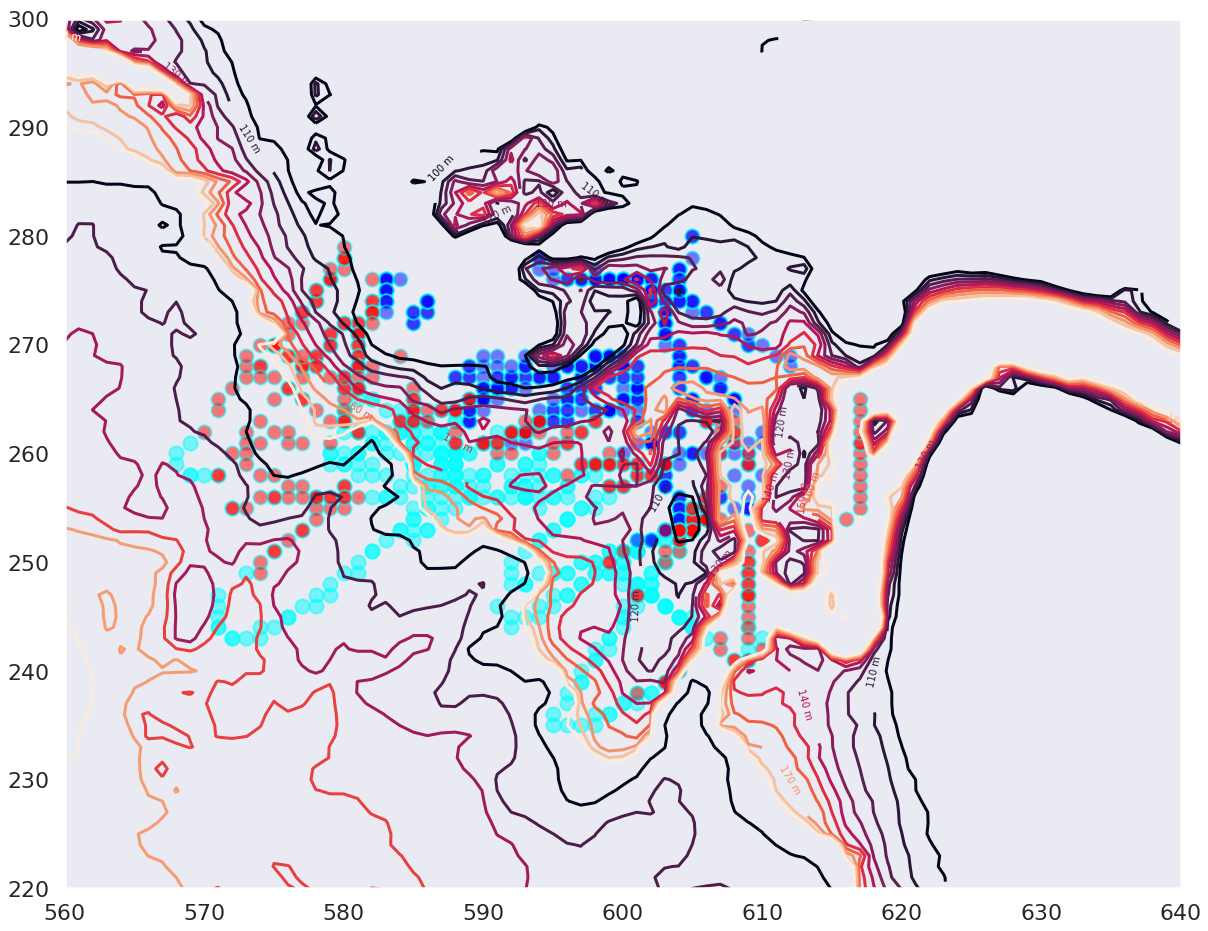

In [54]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

for i in np.arange(x_added_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'blue', alpha= 0.5, s=200, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

In [28]:
from scipy.stats import pearsonr

In [29]:
def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    gamma2,rms_error,ws = get_stat(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
            xy=(.1, .9), xycoords=ax.transAxes)
#     ax.annotate("r = {:.2f}, Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(r, w = ws, r = rms_error, b = gamma2),
#                 xy=(.1, .9), xycoords=ax.transAxes)
#     anchored_text = AnchoredText("r1 = {r1:.2f}, Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(r1=np.float(r1), w = np.float(ws), r = np.float(rms_error), b = np.float(gamma2)), prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=ax.transAxes
#                        )
#     ax.add_artist(anchored_text)
#     return ax
    
    

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


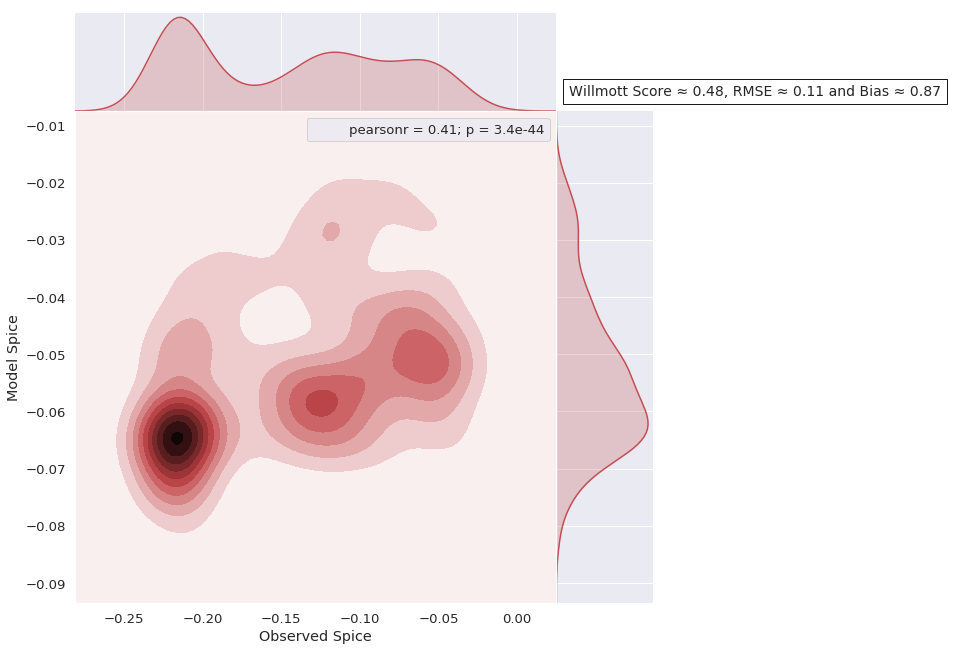

In [13]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)


# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')
fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.4 isopycnal

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


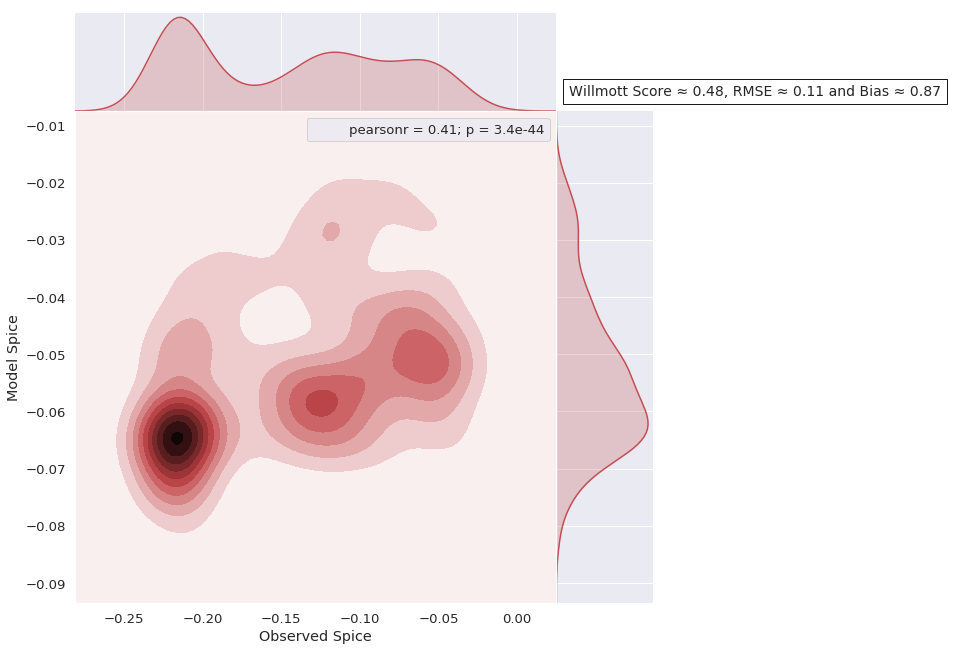

In [13]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.2 isopycnal

In [15]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=2,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


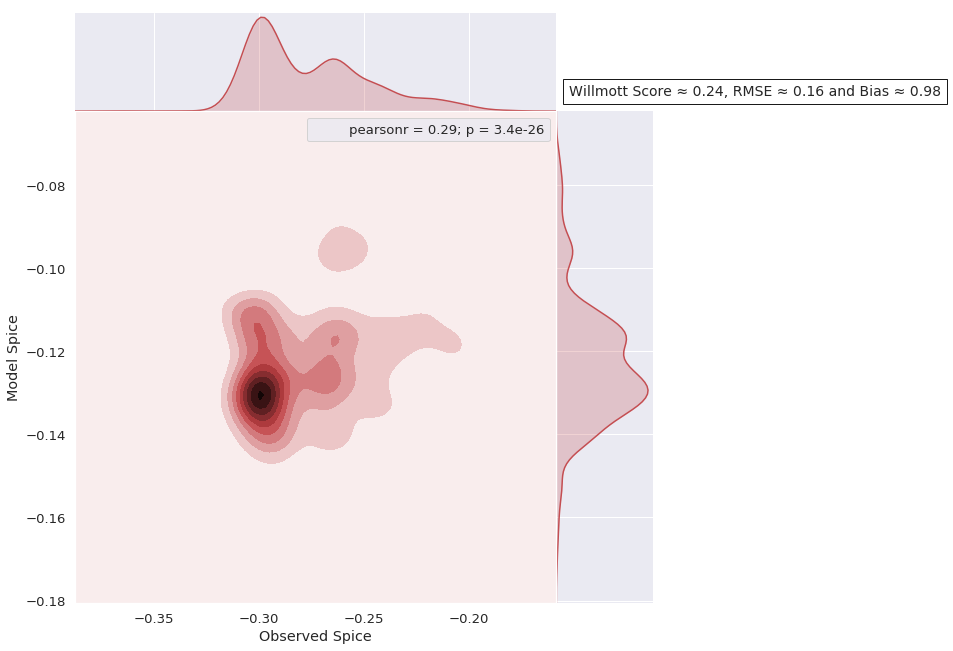

In [17]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')
fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.3 isopycnal

In [18]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=3,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


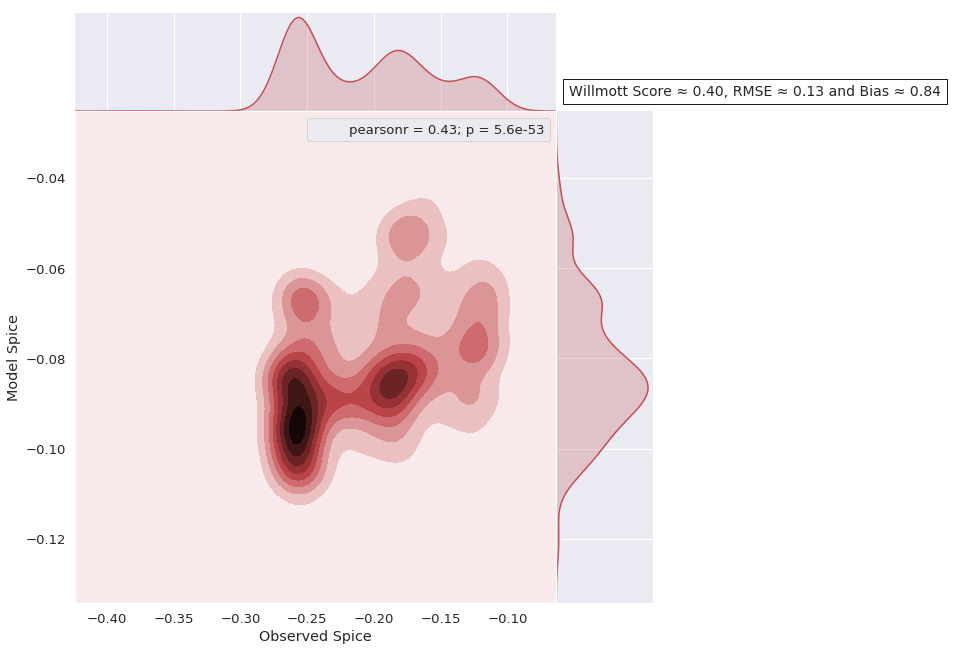

In [19]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')
fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




## After correction

In [20]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_NEP36_2013_along_isopycnal_larger_offshore_rho_correct_temp_improved.nc')
iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]

# iso_NEP_for_mask = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')
# iso_spic_for_mask = iso_NEP_for_mask.variables['spiciness'][...]


# m = np.ma.masked_where(np.isnan(iso_spic_for_mask), iso_spic_for_mask)
# iso_spic = np.ma.masked_array(iso_spic, m.mask)

# # spic_tzyx[np.isnan(spic_tzyx)] = 0
# spic_iso = np.ma.masked_invalid(iso_spic)

isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [21]:
isot[14]

26.4

In [22]:
model_spic = []
survey_iso_spic = []

survey_iso_spic_A, model_spic_A = add_model_MVP_data(survey_file=survey_mat_file_A, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_B, model_spic_B = add_model_MVP_data(survey_file=survey_mat_file_B, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_D, model_spic_D = add_model_MVP_data(survey_file=survey_mat_file_D, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_E, model_spic_E = add_model_MVP_data(survey_file=survey_mat_file_E, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

survey_iso_spic_G, model_spic_G = add_model_MVP_data(survey_file=survey_mat_file_G, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

In [34]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=14,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

### At the 26.4 isopycnal

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


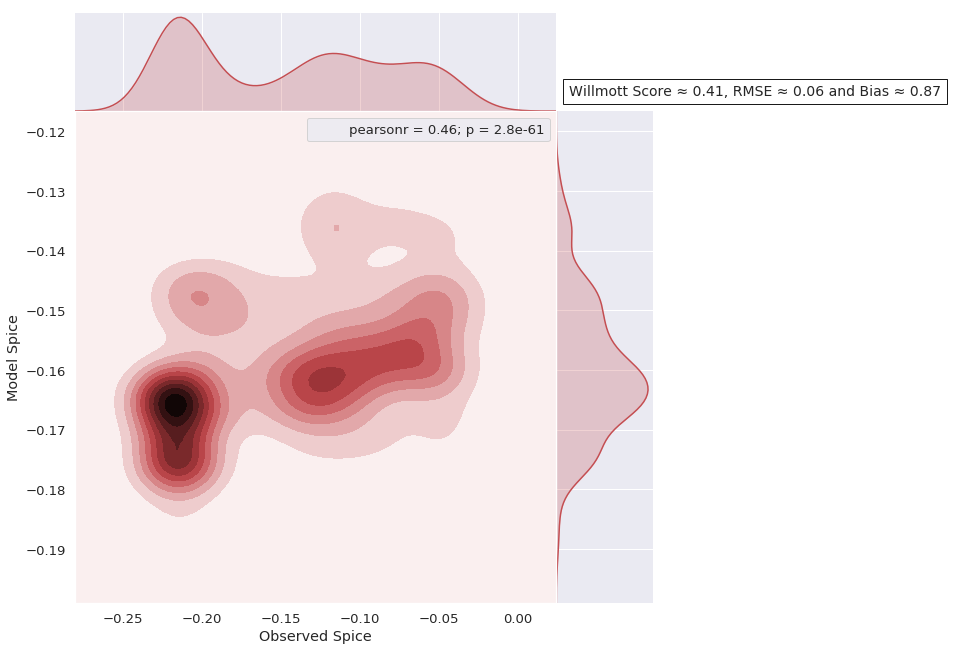

In [35]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10),stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.2 isopycnal

In [32]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=12,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


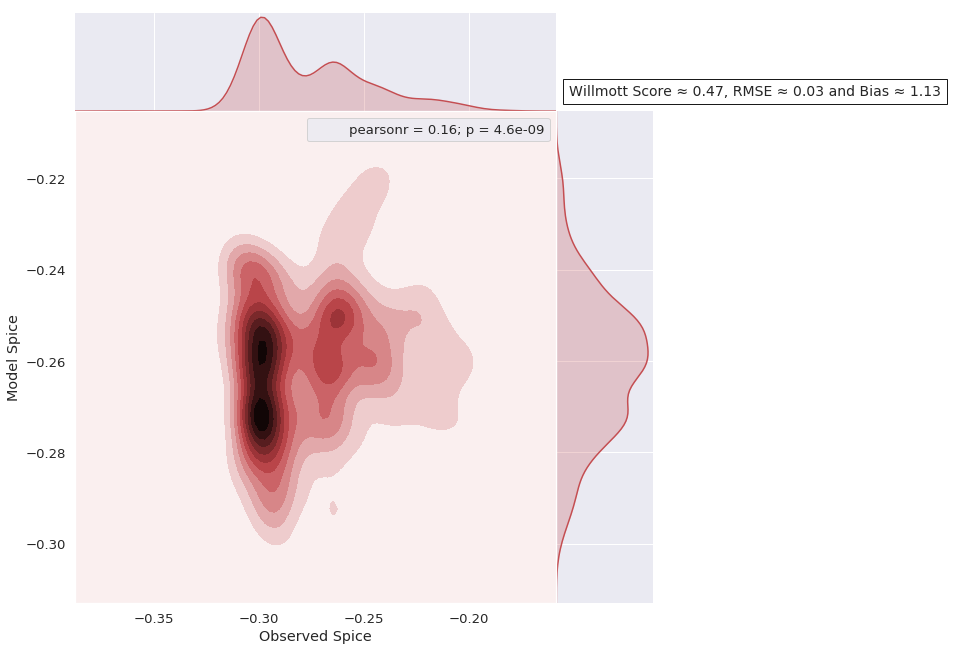

In [33]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




### At the 26.3 isopycnal

In [30]:
model_spic = []
survey_iso_spic = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic = add_model_MVP_data(survey_file=survey_file, \
                                                 iso_level=13,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic)

/home/ssahu/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


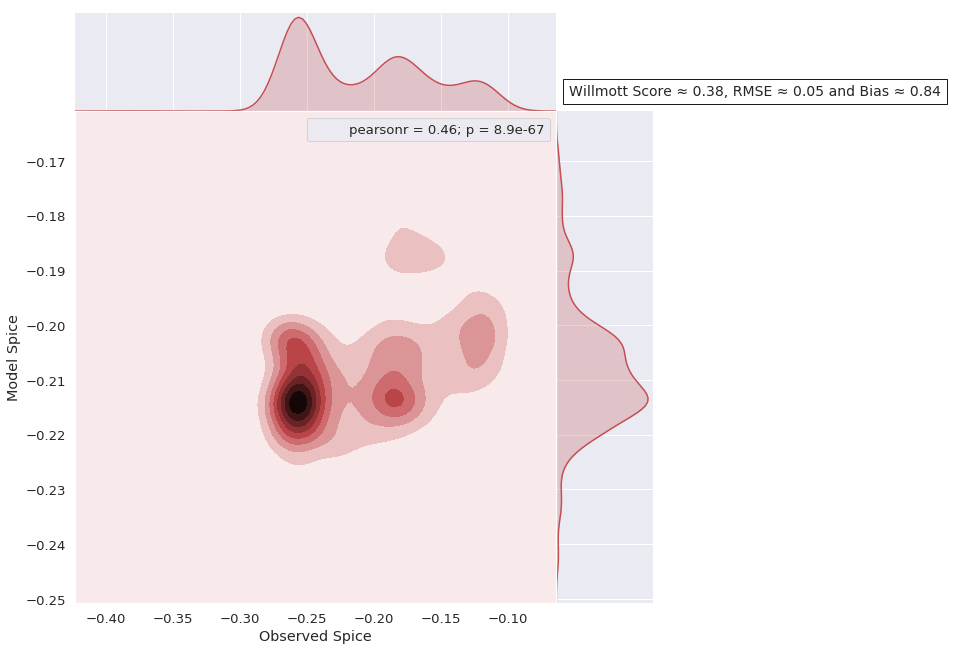

In [31]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = survey_iso_spic
df['Model Spice'] = model_spic


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=pearsonr)
gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
                       bbox_to_anchor=(1., 1.),
                       bbox_transform=q.ax_joint.transAxes
                       )
q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [54]:
print(gamma2,rms_error,ws)

1.1296598751931626 0.0331911620405 0.47488098061176043


In [55]:
isot[13]

26.299999

In [61]:
def calcuate_location_of_kde_custers(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1,\
                                     y_added_2,x_added_2,y_added_3,x_added_3):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]

    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    y_264_cluster_1 = y[spic_rho_finite1<=-0.21]
    x_264_cluster_1 = x[spic_rho_finite1<=-0.21]
    
    y_264_cluster_2 = y[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
    x_264_cluster_2 = x[(spic_rho_finite1<-0.10) & (spic_rho_finite1> -0.16)]
    
    y_264_cluster_3 = y[spic_rho_finite1>=-0.10]
    x_264_cluster_3 = x[spic_rho_finite1>=-0.10]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_264_cluster_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_264_cluster_1)
    
    y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
    x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
    y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
    x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
    return survey_iso_spic, model_spic, y_added_1, x_added_1, y_added_2, x_added_2, y_added_3, x_added_3



In [62]:

    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
y_added_2 = []
x_added_2 = []
y_added_3 = []
x_added_3 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1, \
    y_added_2, x_added_2, y_added_3, x_added_3 \
    = calcuate_location_of_kde_custers(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1,\
                                      y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3)

(560, 640)

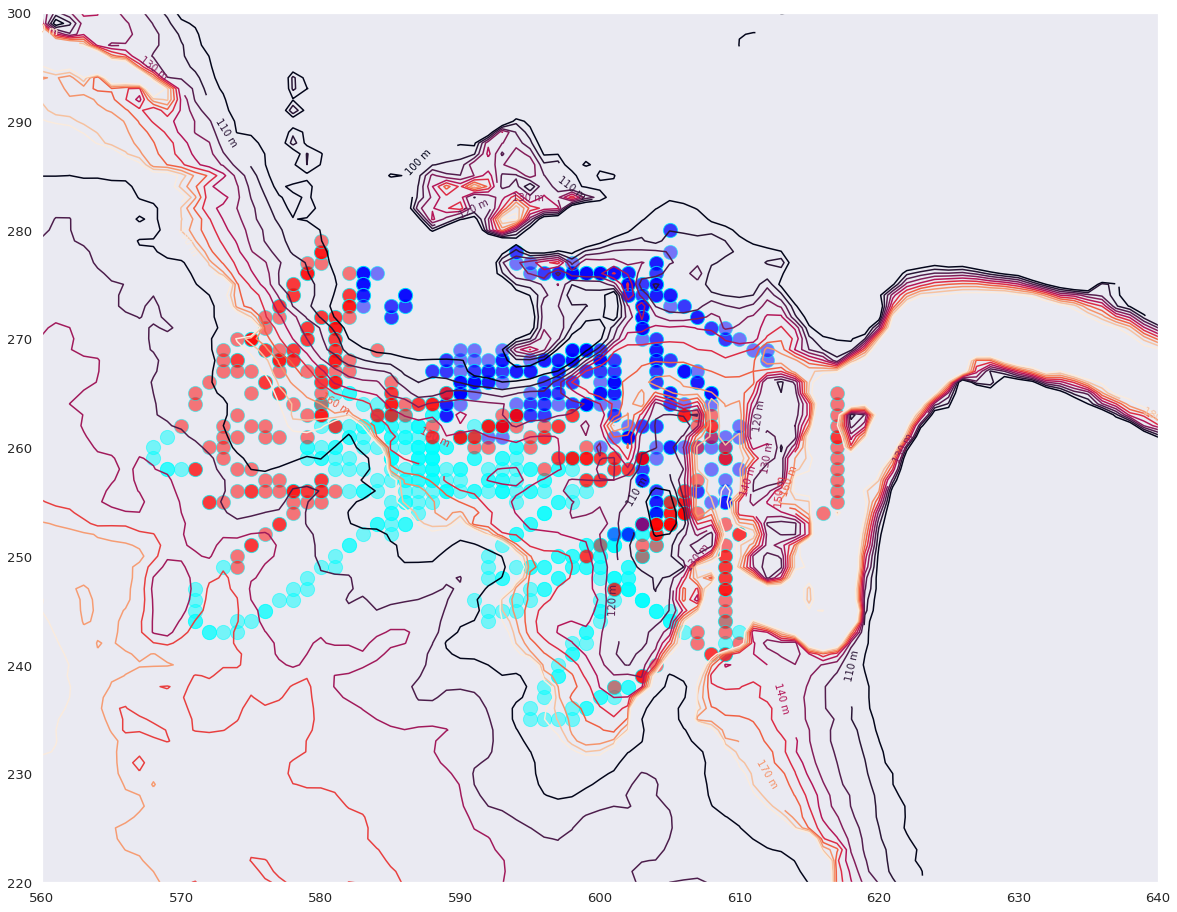

In [63]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

for i in np.arange(x_added_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'blue', alpha= 0.5, s=200, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

(560, 640)

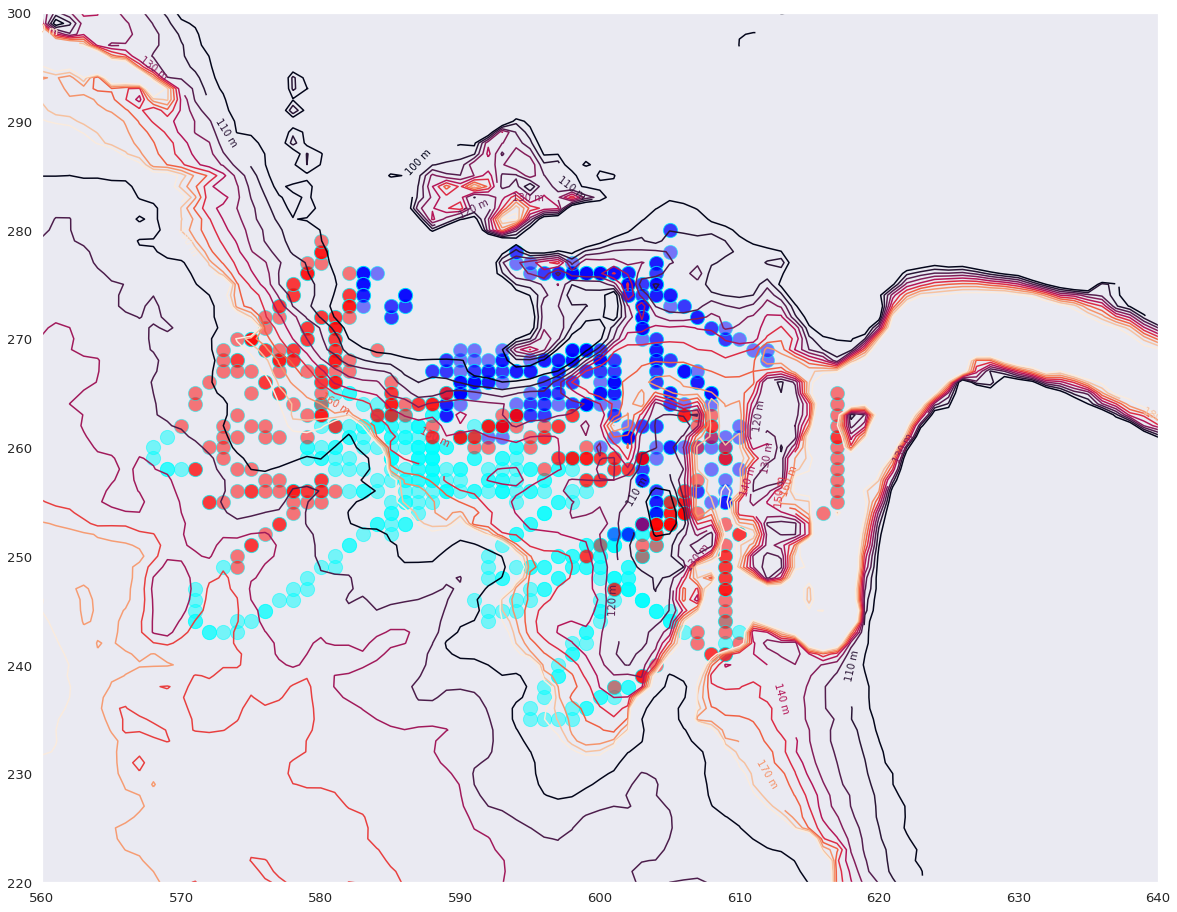

In [48]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

for i in np.arange(x_added_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'blue', alpha= 0.5, s=200, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

In [40]:
x_added_2.shape

(311,)

In [35]:
x_1 = np.empty((x_added_1.shape[0]))

for i in np.arange(x_added_1.shape[0]):
    x_1[i] = np.int(x_added_1[i])

In [41]:
y_wcvi_slice.shape

(170,)

In [64]:
y_added_2.max()

99.0

In [75]:
def calcuate_location_of_kde_custers_model(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1,\
                                     y_added_2,x_added_2,y_added_3,x_added_3):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]


    
    y_264_cluster_1 = y[model_add<=-0.063]
    x_264_cluster_1 = x[model_add<=-0.063]
    
    y_264_cluster_2 = y[(model_add<-0.051) & (model_add> -0.063)]
    x_264_cluster_2 = x[(model_add<-0.051) & (model_add> -0.063)]
    
    y_264_cluster_3 = y[model_add>=-0.051]
    x_264_cluster_3 = x[model_add>=-0.051]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_264_cluster_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_264_cluster_1)
    
    y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
    x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
    y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
    x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic, y_added_1, x_added_1, y_added_2, x_added_2, y_added_3, x_added_3



In [76]:

    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
y_added_2 = []
x_added_2 = []
y_added_3 = []
x_added_3 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1, \
    y_added_2, x_added_2, y_added_3, x_added_3 \
    = calcuate_location_of_kde_custers_model(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1,\
                                      y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in less_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:95: RuntimeWarning: invalid value encountered in less_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in less
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in greater
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in less
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in greater
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:100: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:101: RuntimeWarnin

(560, 640)

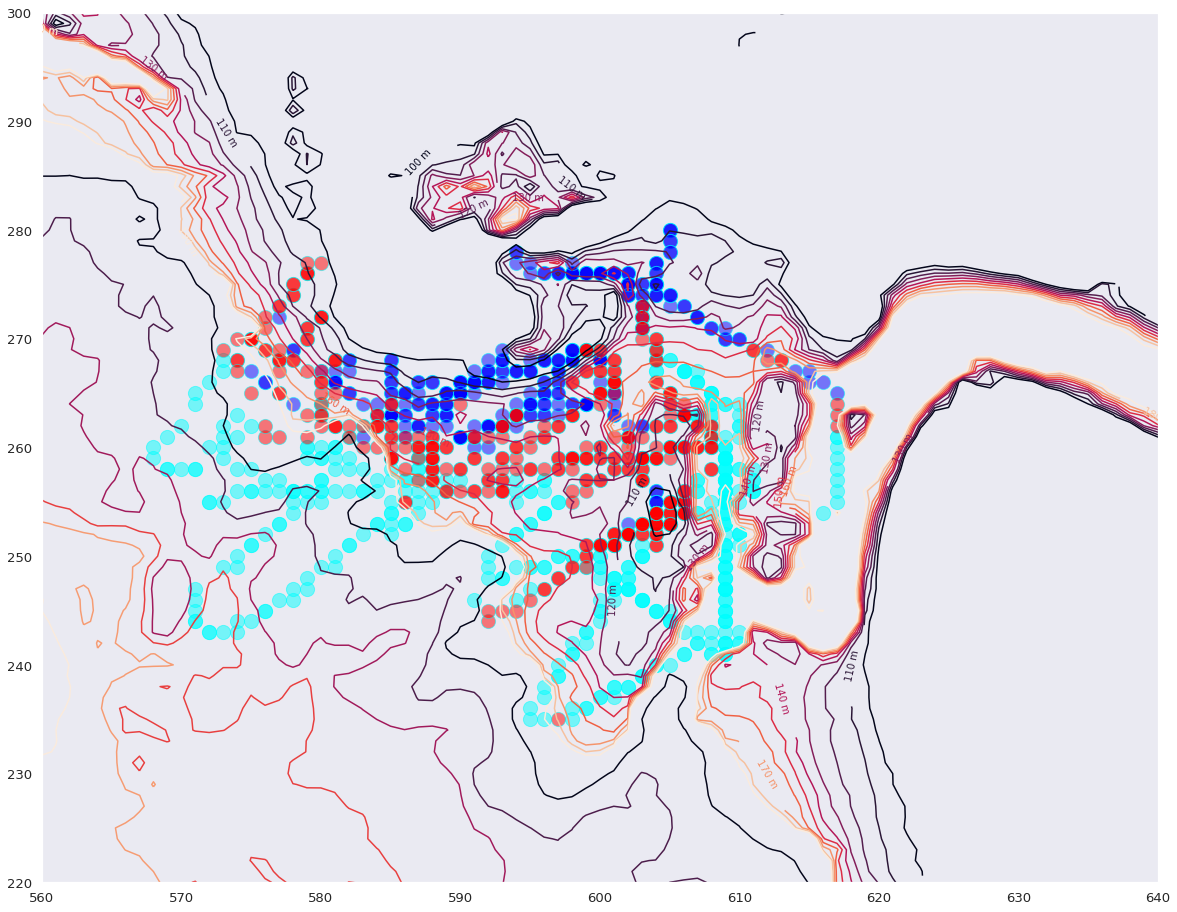

In [77]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

for i in np.arange(x_added_3.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'blue', alpha= 0.5, s=200, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

In [13]:
def calcuate_location_of_kde_custers_model_obs(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1,\
                                     y_added_2,x_added_2,y_added_3,x_added_3):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]


    y_264_cluster_1 = y[(model_add>=-0.55) & (spic_rho_finite1 <= -0.17)]
    x_264_cluster_1 = x[(model_add>=-0.55) & (spic_rho_finite1 <= -0.17)]
    
    y_264_cluster_2 = y[(model_add>=-0.37) & (spic_rho_finite1 > -0.17)]
    x_264_cluster_2 = x[(model_add>=-0.37) & (spic_rho_finite1 > -0.17)]
    
#     y_264_cluster_1 = y[model_add<=-0.063]
#     x_264_cluster_1 = x[model_add<=-0.063]
    
#     y_264_cluster_2 = y[(model_add<-0.051) & (model_add> -0.063)]
#     x_264_cluster_2 = x[(model_add<-0.051) & (model_add> -0.063)]
    
    y_264_cluster_3 = y[model_add>=-0.051]
    x_264_cluster_3 = x[model_add>=-0.051]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_264_cluster_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_264_cluster_1)
    
    y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
    x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
    y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
    x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic, y_added_1, x_added_1, y_added_2, x_added_2, y_added_3, x_added_3



In [14]:

    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
y_added_2 = []
x_added_2 = []
y_added_3 = []
x_added_3 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1, \
    y_added_2, x_added_2, y_added_3, x_added_3 \
    = calcuate_location_of_kde_custers_model_obs(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1,\
                                      y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:105: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:106: RuntimeWarning: invalid value encountered in greater_equal


(560, 640)

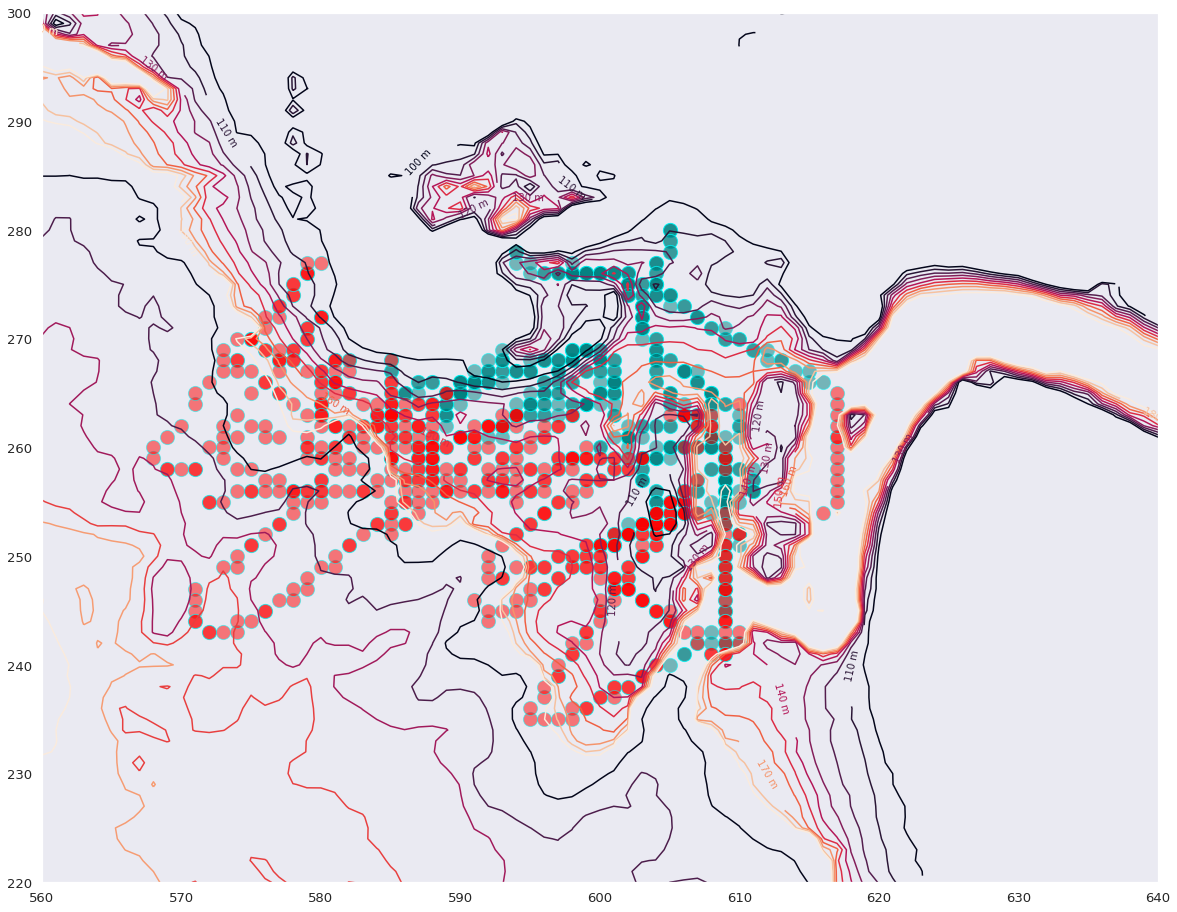

In [16]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'teal', alpha= 0.5, s=200)#, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200)#, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

In [47]:
def calcuate_location_of_kde_custers_model_obs(survey_file, iso_level, survey_iso_spic, model_spic, y_added_1,x_added_1,\
                                     y_added_2,x_added_2,y_added_3,x_added_3):
    
    mat = scipy.io.loadmat(survey_file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]

    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    mbathy = mask.variables['mbathy']#[0,220:280, 575:630]
    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][180:350,480:650]
    lat = bathy['nav_lat'][180:350,480:650]


    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)

            #Values indicate that pden is the true representative of the potential density calculated by rho_survey here


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    rho_0 = isot[iso_level]

    spic_rho = np.empty((spic_survey.shape[1]))


    for i in np.arange(spic_survey.shape[1]):

        spic_loc = spic_survey[:,i]
        rho_loc  = rho_survey[:,i]

        spic_rho[i] = np.interp(rho_0, rho_loc[:]-1000, spic_loc[:])

    spic_rho_finite1 = spic_rho[~np.isnan(spic_rho)]



    y = y[~np.isnan(spic_rho)]
    x = x[~np.isnan(spic_rho)]
    
    if survey_file == survey_mat_file_A:
        t =116
    if survey_file == survey_mat_file_B:
        t =116
    if survey_file == survey_mat_file_D:
        t =118
    if survey_file == survey_mat_file_E:
        t =119
    if survey_file == survey_mat_file_G:
        t =120

    model_add = np.empty_like(y)

    for i in np.arange(y.shape[0]):
        model_add[i] = iso_spic[t,iso_level,np.int(y[i]),np.int(x[i])]


    y_264_cluster_1 = y[(model_add>=-0.055) & (spic_rho_finite1 <= -0.17)]
    x_264_cluster_1 = x[(model_add>=-0.055) & (spic_rho_finite1 <= -0.17)]
    
    y_264_cluster_2 = y[(model_add>=-0.037) & (spic_rho_finite1 > -0.17)]
    x_264_cluster_2 = x[(model_add>=-0.037) & (spic_rho_finite1 > -0.17)]
    
#     y_264_cluster_1 = y[model_add<=-0.063]
#     x_264_cluster_1 = x[model_add<=-0.063]
    
#     y_264_cluster_2 = y[(model_add<-0.051) & (model_add> -0.063)]
#     x_264_cluster_2 = x[(model_add<-0.051) & (model_add> -0.063)]
    
    y_264_cluster_3 = y[model_add>=-0.051]
    x_264_cluster_3 = x[model_add>=-0.051]
    
    y_added_1 = np.append(arr= y_added_1,  values= y_264_cluster_1)
    x_added_1 = np.append(arr= x_added_1,  values= x_264_cluster_1)
    
    y_added_2 = np.append(arr= y_added_2,  values= y_264_cluster_2)
    x_added_2 = np.append(arr= x_added_2,  values= x_264_cluster_2)
    
    y_added_3 = np.append(arr= y_added_3,  values= y_264_cluster_3)
    x_added_3 = np.append(arr= x_added_3,  values= x_264_cluster_3)
    
    spic_rho_finite = spic_rho_finite1[~np.isnan(model_add)]
    model_add = model_add[~np.isnan(model_add)]
    
#     model_add[np.isnan(model_add)] = 0
#     model_add = np.ma.masked_equal(model_add, value=0)



    survey_iso_spic = np.append(arr= survey_iso_spic,  values= spic_rho_finite)
    
    

    model_spic = np.append(arr= model_spic, values=model_add)
    
    return survey_iso_spic, model_spic, y_added_1, x_added_1, y_added_2, x_added_2, y_added_3, x_added_3



In [48]:

    
    
model_spic = []
survey_iso_spic = []

y_added_1 = []
x_added_1 = []
y_added_2 = []
x_added_2 = []
y_added_3 = []
x_added_3 = []

for survey_file in all_surveys:
    survey_iso_spic, model_spic, y_added_1, x_added_1, \
    y_added_2, x_added_2, y_added_3, x_added_3 \
    = calcuate_location_of_kde_custers_model_obs(survey_file=survey_file, \
                                                 iso_level=4,model_spic=model_spic, \
                                                 survey_iso_spic=survey_iso_spic,y_added_1=y_added_1,x_added_1=x_added_1,\
                                      y_added_2=y_added_2,x_added_2=x_added_2,y_added_3=y_added_3,x_added_3=x_added_3)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:105: RuntimeWarning: invalid value encountered in greater_equal
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:106: RuntimeWarning: invalid value encountered in greater_equal


(560, 640)

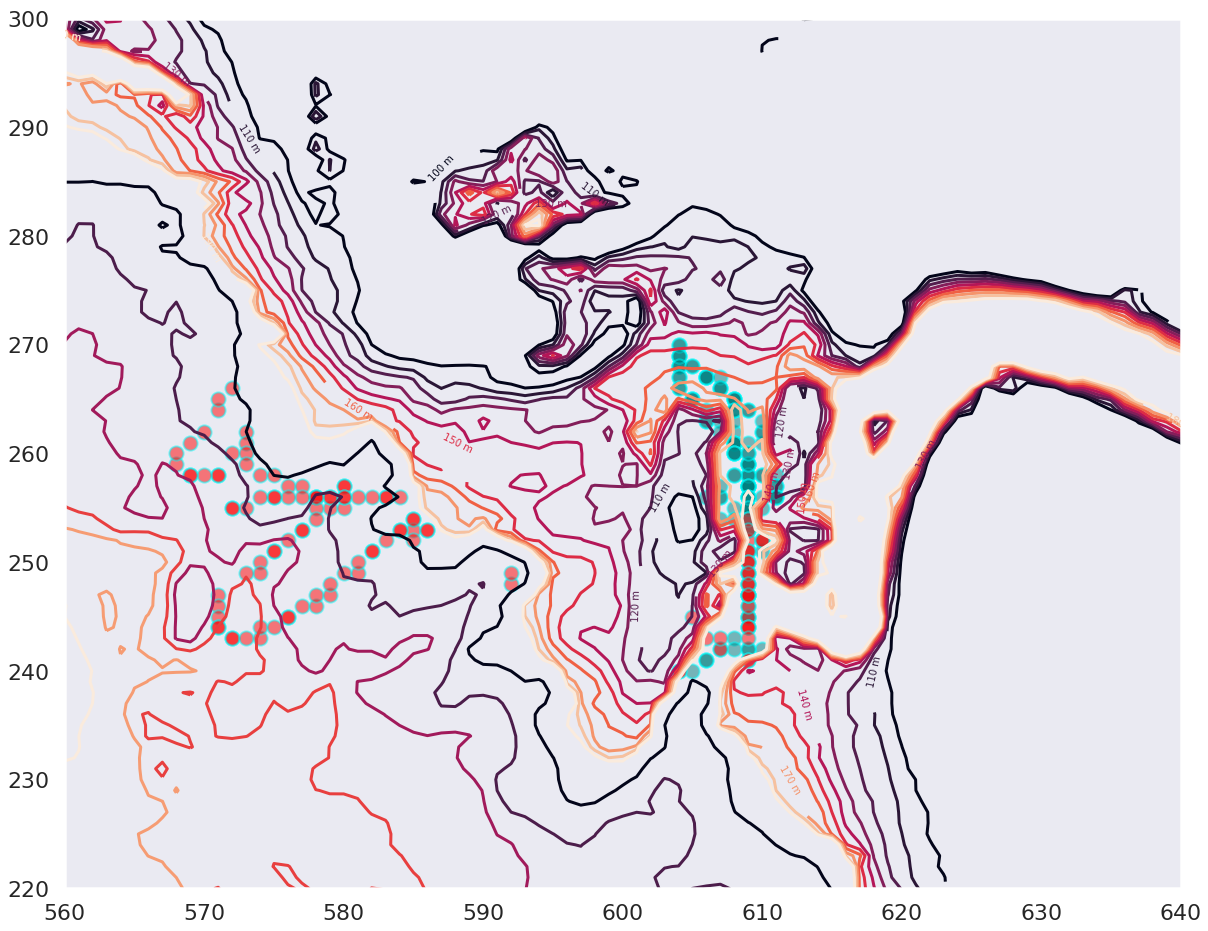

In [60]:


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon']
lat = bathy['nav_lat']
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


cmap = plt.get_cmap('plasma')
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')
fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)

# q = ax.pcolormesh(x_wcvi_slice, y_wcvi_slice, val_iso[:], cmap=cmap, vmin= cmin, vmax= cmax)
# cbar = fig.colorbar(q, ax=ax)

# for i in np.arange(x_added_3.shape[0]):

#     ax.scatter(x_wcvi_slice[np.int(x_added_3[i])], y_wcvi_slice[np.int(y_added_3[i])], c = 'cyan', alpha =0.5, s=200, edgecolor= 'cyan')



for i in np.arange(x_added_1.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_1[i])], y_wcvi_slice[np.int(y_added_1[i])], c = 'teal', alpha= 0.5, s=200, edgecolor= 'cyan')

for i in np.arange(x_added_2.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(x_added_2[i])], y_wcvi_slice[np.int(y_added_2[i])], c = 'red', alpha =0.5, s=200, edgecolor= 'cyan')

ax.set_ylim(220,300)
ax.set_xlim(560,640)

26.4